In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms, datasets
import random

import os

from sklearn.metrics import f1_score, confusion_matrix
from ultralytics import YOLO
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
num_classes = 36
batch_size = 32
learning_rate = 0.001
num_epochs = 50

In [4]:
# Definisikan transformasi untuk preprocessing
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Ubah ukuran gambar menjadi 64x64 piksel
    transforms.Grayscale(),  # Ubah gambar menjadi grayscale (1 channel)
    transforms.ToTensor()  # Konversi gambar ke tensor
])

In [5]:
train_path = r'C:\Users\Ilham Mafani Nadif\Videos\Deteksi Plat Nomor\karakter\train'
val_path =  r'C:\Users\Ilham Mafani Nadif\Videos\Deteksi Plat Nomor\karakter\valid'
test_path =  r'C:\Users\Ilham Mafani Nadif\Videos\Deteksi Plat Nomor\karakter\test'

train_data = datasets.ImageFolder(train_path, transform=transform)
val_data = datasets.ImageFolder(val_path, transform=transform)
test_data = datasets.ImageFolder(test_path, transform=transform)

folders = os.listdir(train_path)
array_label = np.array(folders)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [6]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 16 * 16, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [7]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    feature_values = []

    for images, labels in dataloader:
        images = images.to(device) 
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        features = model.features(images)
        feature_values.append(features.detach().cpu())

    epoch_loss = running_loss / len(dataloader.dataset)

    feature_values = torch.cat(feature_values, dim=0)
    feature_std = torch.std(feature_values, dim=0)
    return epoch_loss, feature_std

def evaluate(model, dataloader, device):
    model.eval()  # Set model ke mode evaluasi
    predictions = []
    true_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)  # Pindahkan input ke perangkat
            labels = labels.to(device)  # Pindahkan label ke perangkat

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return predictions, true_labels

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score

num_training_runs = 10
train_losses_list = []
valid_losses_list = []
train_f1_list = []
valid_f1_list = []
test_f1_list = []
all_std_dev_mean_list = []

models = {}

for run in range(num_training_runs):
    model_name = f"model_{run}"
    models[model_name] = CNN(num_classes)
    models[model_name] = models[model_name].to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(models[model_name].parameters(), lr=learning_rate)

    best_valid_loss = float('inf')
    train_losses = []
    valid_losses = []
    all_std_dev = []

    for epoch in range(num_epochs):
        train_loss, feature_std = train(models[model_name], train_loader, criterion, optimizer, device)
        valid_loss, _ = train(models[model_name], val_loader, criterion, optimizer, device)
        
        mean_std = feature_std.mean().item()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        all_std_dev.append(mean_std)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Std Deviation: {mean_std:.4f}')

    train_predictions, train_labels = evaluate(models[model_name], train_loader, device)
    train_f1 = f1_score(train_labels, train_predictions, average='weighted')
    train_f1_list.append(train_f1)

    valid_predictions, valid_labels = evaluate(models[model_name], val_loader, device)
    valid_f1 = f1_score(valid_labels, valid_predictions, average='weighted')
    valid_f1_list.append(valid_f1)

    test_predictions, test_labels = evaluate(models[model_name], test_loader, device)
    test_f1 = f1_score(test_labels, test_predictions, average='weighted')
    test_f1_list.append(test_f1)

    all_std_dev_mean = sum(all_std_dev) / len(all_std_dev)
    print(f'Run {run + 1} | Train Accuracy: {train_f1:.4f}, Valid Accuracy: {valid_f1:.4f}, Test Accuracy: {test_f1:.4f}, Standard Deviation: {all_std_dev_mean:.4f}')

    train_losses_list.append(train_losses)
    valid_losses_list.append(valid_losses)

    all_std_dev_mean_list.append(all_std_dev_mean)

    print('Training complete!')

avg_all_train_losses = torch.tensor(train_losses_list).mean(dim=0).tolist()
avg_all_valid_losses = torch.tensor(valid_losses_list).mean(dim=0).tolist()

avg_all_train_f1 = sum(train_f1_list) / len(train_f1_list)
avg_all_valid_f1 = sum(valid_f1_list) / len(valid_f1_list)
avg_all_test_f1 = sum(test_f1_list) / len(test_f1_list)
avg_all_std_dev_mean = sum(all_std_dev_mean_list) / len(all_std_dev_mean_list)

print(f'Average Train Accuracy: {avg_all_train_f1:.4f}')
print(f'Average Valid Accuracy: {avg_all_valid_f1:.4f}')
print(f'Average Test Accuracy: {avg_all_test_f1:.4f}')
print(f'Average Standard Deviation: {avg_all_std_dev_mean:.4f}')


Epoch [1/50], Train Loss: 0.9066, Valid Loss: 3.0279, Std Deviation: 0.3058
Epoch [2/50], Train Loss: 0.5327, Valid Loss: 1.3367, Std Deviation: 0.1137
Epoch [3/50], Train Loss: 0.3216, Valid Loss: 0.3432, Std Deviation: 0.0907
Epoch [4/50], Train Loss: 0.3083, Valid Loss: 0.2855, Std Deviation: 0.0879
Epoch [5/50], Train Loss: 0.2179, Valid Loss: 0.1387, Std Deviation: 0.0860
Epoch [6/50], Train Loss: 0.0910, Valid Loss: 0.0562, Std Deviation: 0.0967
Epoch [7/50], Train Loss: 0.0377, Valid Loss: 0.0429, Std Deviation: 0.1143
Epoch [8/50], Train Loss: 0.0459, Valid Loss: 0.0264, Std Deviation: 0.1176
Epoch [9/50], Train Loss: 0.0316, Valid Loss: 0.0233, Std Deviation: 0.1221
Epoch [10/50], Train Loss: 0.0373, Valid Loss: 0.0218, Std Deviation: 0.1221
Epoch [11/50], Train Loss: 0.0247, Valid Loss: 0.0160, Std Deviation: 0.1264
Epoch [12/50], Train Loss: 0.0259, Valid Loss: 0.0153, Std Deviation: 0.1262
Epoch [13/50], Train Loss: 0.0144, Valid Loss: 0.0068, Std Deviation: 0.1337
Epoch [1

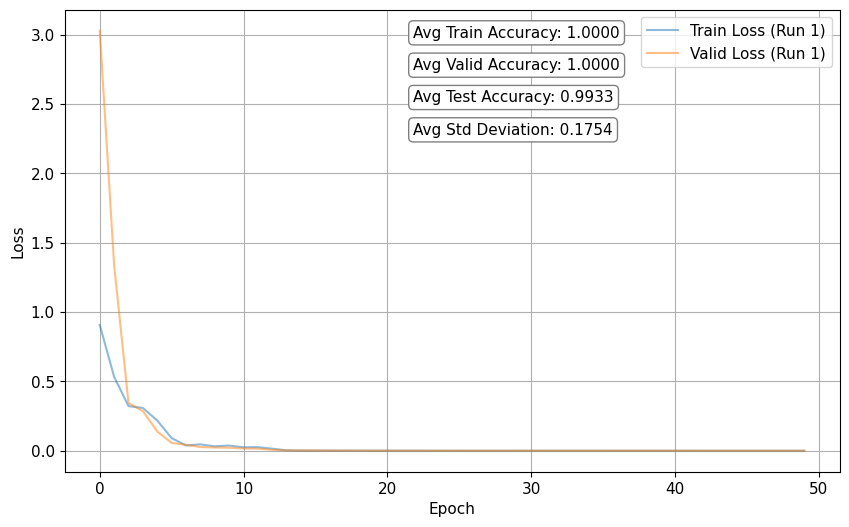

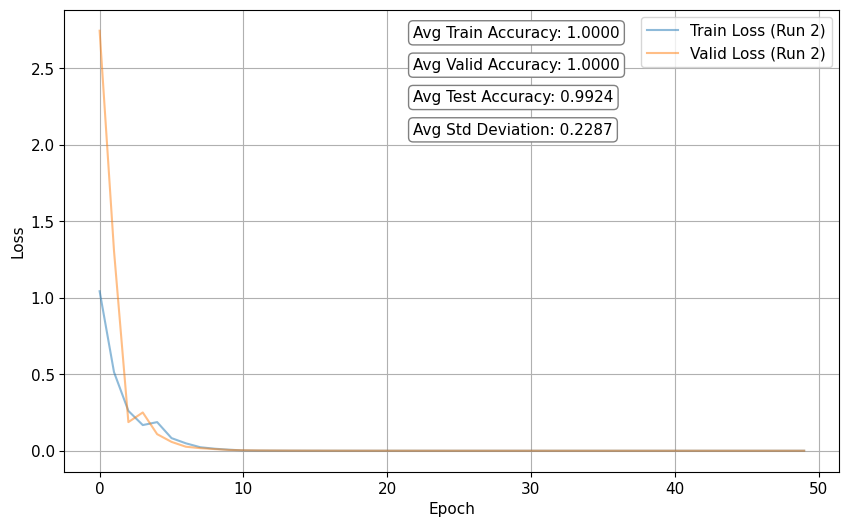

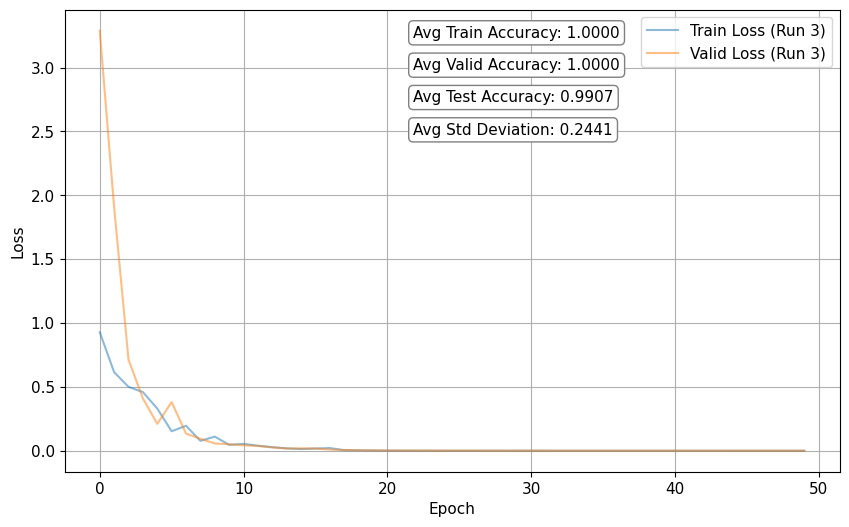

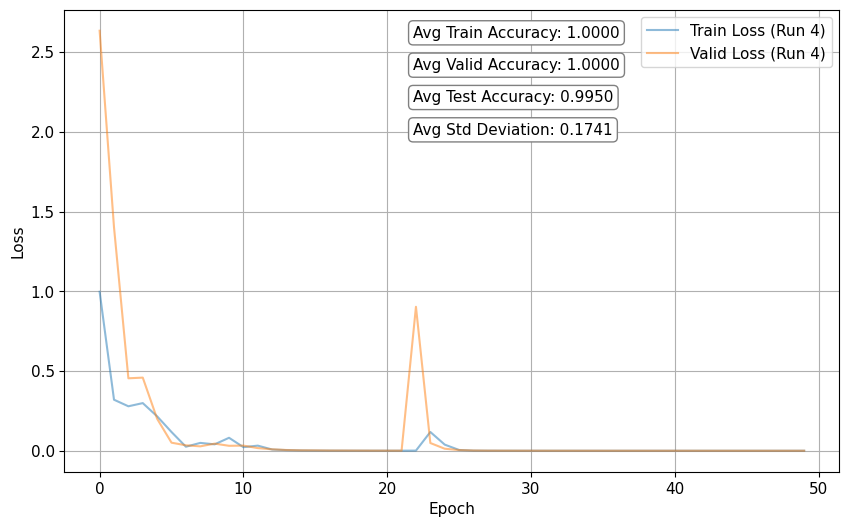

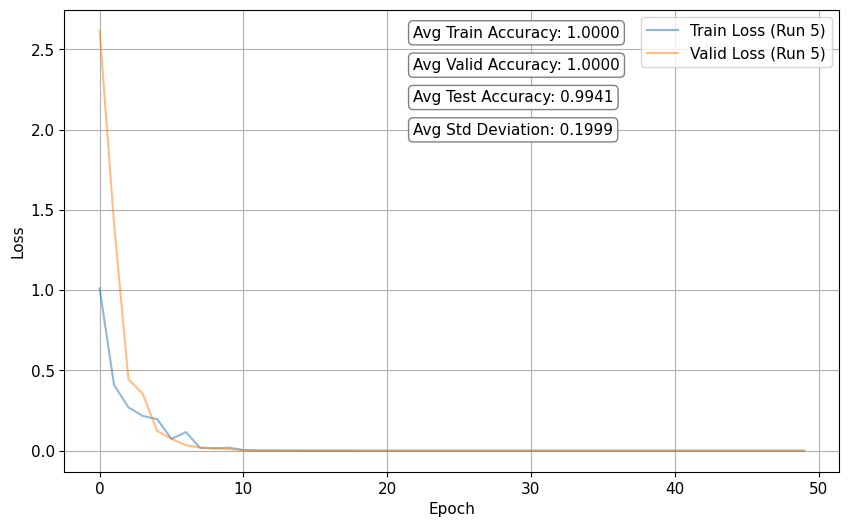

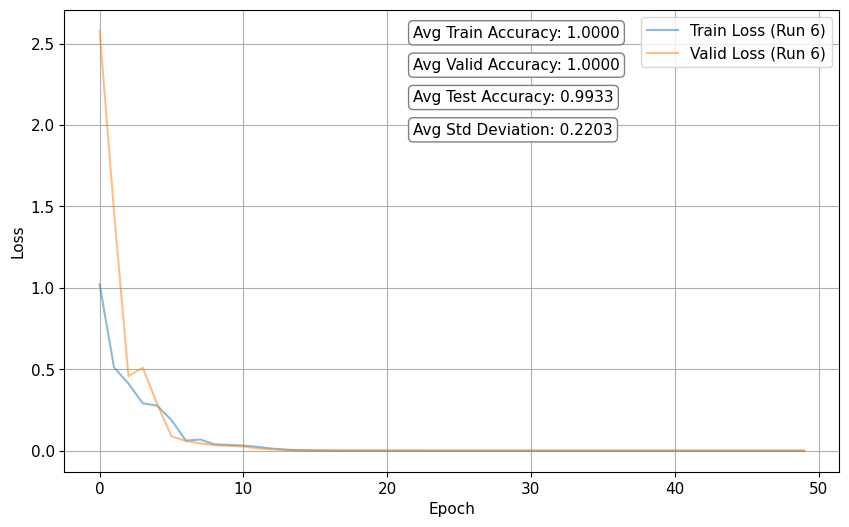

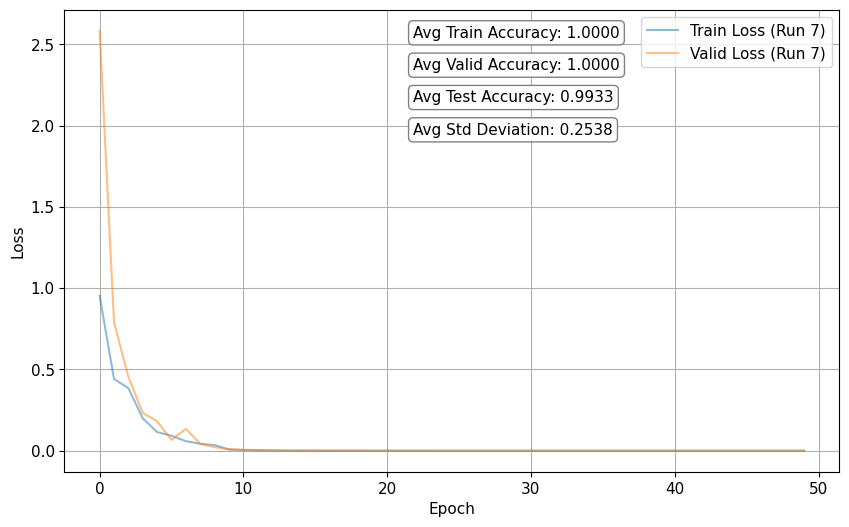

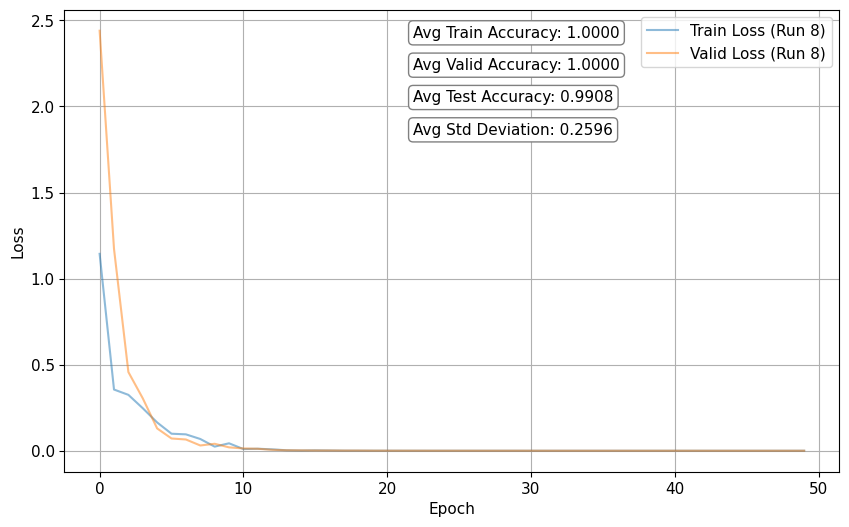

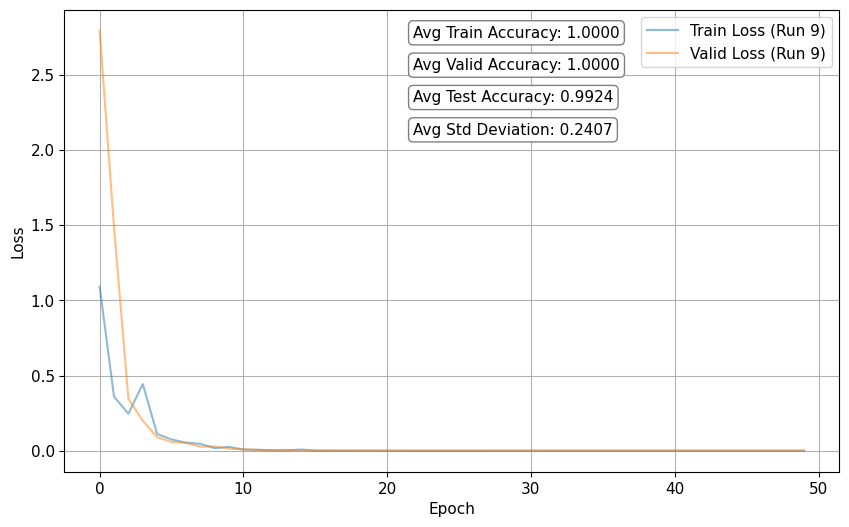

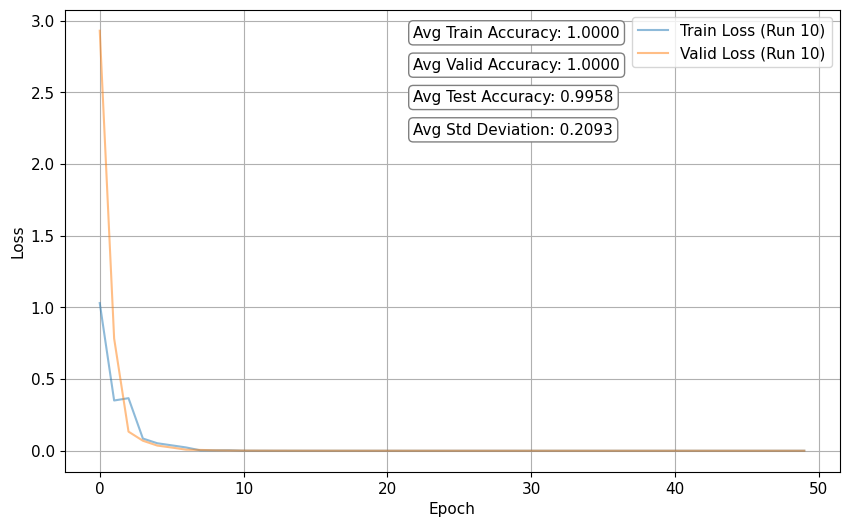

In [9]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# Assuming you have 'num_training_runs', 'num_epochs', 'train_losses_list', 'valid_losses_list', 'test_f1_list', and 'all_std_dev_mean_list' defined.

# Loop through each training run and create a separate plot for each
for run in range(num_training_runs):
    # Create a new figure for each training run
    plt.figure(figsize=(10, 6))
    
    # Plot the training loss for the current run
    plt.plot(range(num_epochs), train_losses_list[run], label=f'Train Loss (Run {run + 1})', alpha=0.5)
    
    # Plot the validation loss for the current run
    plt.plot(range(num_epochs), valid_losses_list[run], label=f'Valid Loss (Run {run + 1})', alpha=0.5)

    # Calculate and display average training and validation losses
    avg_train_loss = torch.tensor(train_losses_list[run]).mean().item()
    avg_valid_loss = torch.tensor(valid_losses_list[run]).mean().item()
  
    x_position, y_position = 0.45, 0.95

    # Create a dictionary for the bbox properties
    bbox_props = dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray")

    # Display the text with background and border using plt.annotate()
    plt.annotate(f'Avg Train Accuracy: {train_f1_list[run]:.4f}', xy=(x_position, y_position), xycoords='axes fraction',
                ha='left', va='center', bbox=bbox_props)

    # Move to the next line
    y_position -= 0.07
    plt.annotate(f'Avg Valid Accuracy: {valid_f1_list[run]:.4f}', xy=(x_position, y_position), xycoords='axes fraction',
                ha='left', va='center', bbox=bbox_props)

    # Move to the next line
    y_position -= 0.07
    plt.annotate(f'Avg Test Accuracy: {test_f1_list[run]:.4f}', xy=(x_position, y_position), xycoords='axes fraction',
                ha='left', va='center', bbox=bbox_props)

    # Move to the next line
    y_position -= 0.07
    plt.annotate(f'Avg Std Deviation: {all_std_dev_mean_list[run]:.4f}', xy=(x_position, y_position), xycoords='axes fraction',
                ha='left', va='center', bbox=bbox_props)

    # Set the label for the x-axis
    plt.xlabel('Epoch')

    # Set the label for the y-axis
    plt.ylabel('Loss')

    # Add a legend to the plot to distinguish the training and validation losses for the current run
    plt.legend()

    # Add gridlines to the plot
    plt.grid(True)

    # Display the plot for the current run
    plt.show()